In [31]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from pathlib import Path
from cai_robustness_metrics.metrics.calibration import ECE
from scipy.special import softmax
from sklearn.metrics import roc_auc_score, roc_curve
sns.set(color_codes=True)
%matplotlib inline

def plot_roc_auc(targets, probs):
    """
        Plots the ROC curve and AUC score of the models results
    """
    auc = roc_auc_score(targets, probs)
    print(' ROC AUC=%.5f' % (auc))

    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return auc

WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"

In [32]:
NAME = 'resnetensemble'
EXP_ID =  '19'

mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
df_runs = mlflow.search_runs(
    experiment_ids=EXP_ID,
    filter_string="tags.type = 'ensemble + quantization + ood'",
    output_format="pandas"
)

#runs = df_runs[df_runs[WP] == '2']
#runs
runs = df_runs

os.listdir(runs.iloc[0]["params.csv_path"])

['q_preds.csv', 'ood_preds.csv', 'q_ood_preds.csv', 'preds.csv']

In [33]:
def auc_ood(run, file_prefix, type = None, quant = False):
    fig, ax = plt.subplots(figsize=(10,8))
    sns.set_palette("tab10")

    path = run["params.csv_path"]

    df = pd.read_csv(path + f"/{file_prefix}preds.csv")
    df_ood = pd.read_csv(path + f"/{file_prefix}ood_preds.csv")


    preds = df.iloc[:,0:9].to_numpy()
    preds = softmax(preds, axis=1)
    vals = np.max(preds, axis=1)

    preds_ood = df_ood.iloc[:,0:9].to_numpy()
    preds_ood = softmax(preds_ood, axis=1)
    vals_ood = np.max(preds_ood, axis=1)

    targets = np.concatenate(
            (np.zeros(len(vals_ood)), np.ones(len(vals))))
    results = np.concatenate((vals_ood, vals))


    auc = plot_roc_auc(targets, results)
    prefix = type if type else 'fp'
    q = ''
    if quant and type:
        q = f" W{run[WP]}A{run[AP]}"
    plt.title(f"OOD {NAME} {prefix}{q} - AUC: {auc}")
    plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/ood/{NAME}/{prefix}{q}.jpg')



 ROC AUC=0.79018


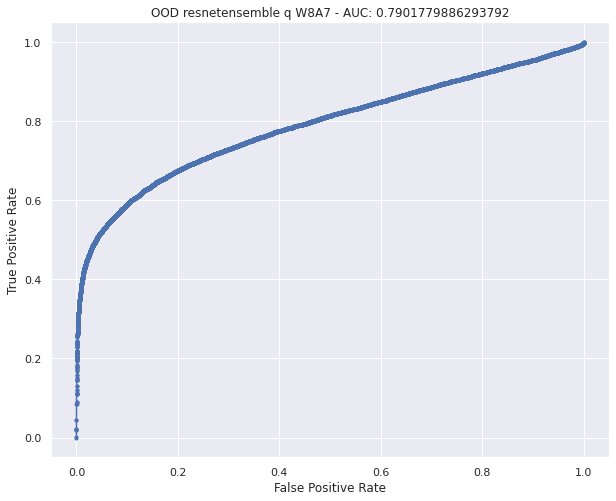

In [34]:
auc_ood(runs.iloc[0], '',  type=None, quant=True)

 ROC AUC=0.73104


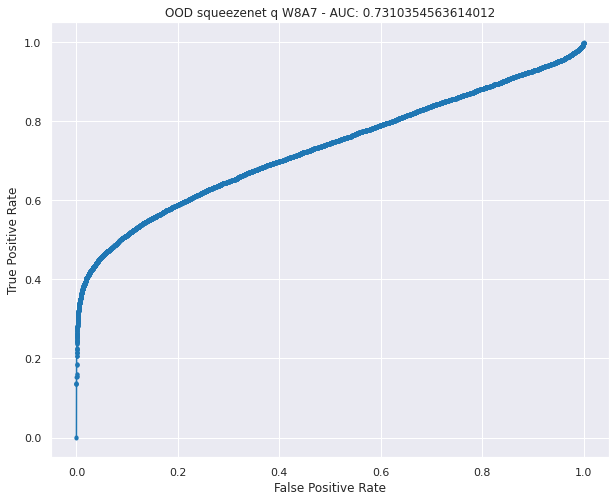

In [76]:
auc_ood(runs.iloc[0], 'q', True, '')

 ROC AUC=0.80509


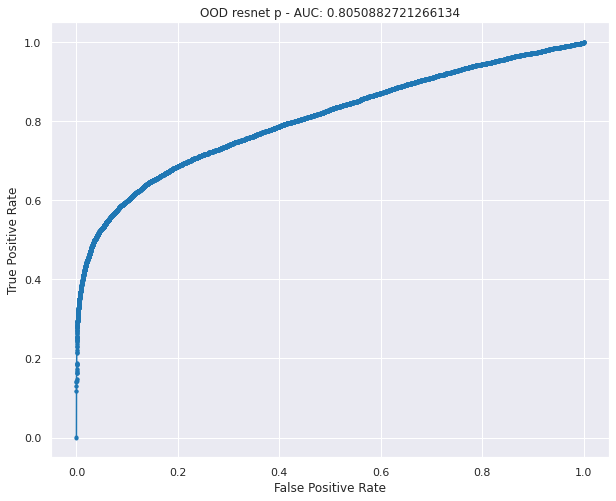

In [69]:
auc_ood(runs.iloc[0], 'p', False)

 ROC AUC=0.74728


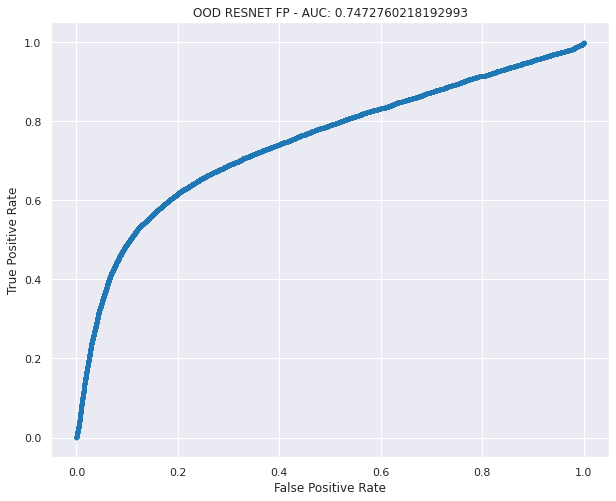

In [6]:
# FULL PRECISION
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")

run = runs.iloc[0]
path = run["params.csv_path"]

df = pd.read_csv(path + f"/preds.csv")
df_ood = pd.read_csv(path + f"/ood_preds.csv")


preds = df.iloc[:,0:9].to_numpy()
preds = softmax(preds, axis=1)
vals = np.max(preds, axis=1)

preds_ood = df_ood.iloc[:,0:9].to_numpy()
preds_ood = softmax(preds_ood, axis=1)
vals_ood = np.max(preds_ood, axis=1)

targets = np.concatenate(
        (np.zeros(len(vals_ood)), np.ones(len(vals))))
results = np.concatenate((vals_ood, vals))


auc = plot_roc_auc(targets, results)
plt.title(f"OOD {NAME} FP - AUC: {auc}")
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/ood/{NAME}-fp.jpg')


 ROC AUC=0.74595


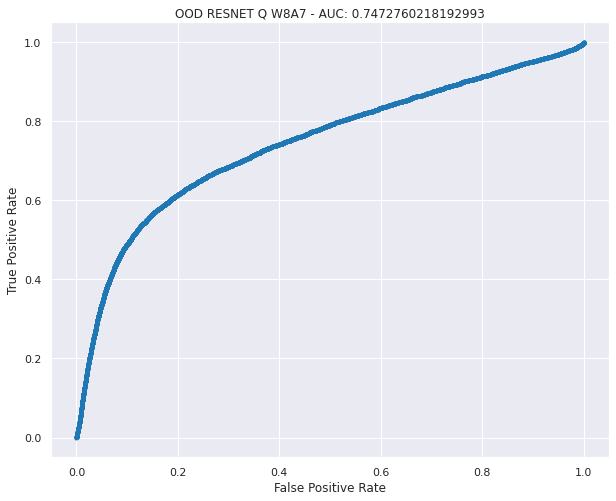

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")

run = runs.iloc[2]
path = run["params.csv_path"]
df = pd.read_csv(path + f"/q_preds.csv")
df_ood = pd.read_csv(path + f"/q_ood_preds.csv")


preds = df.iloc[:,0:9].to_numpy()
preds = softmax(preds, axis=1)
vals = np.max(preds, axis=1)

preds_ood = df_ood.iloc[:,0:9].to_numpy()
preds_ood = softmax(preds_ood, axis=1)
vals_ood = np.max(preds_ood, axis=1)

targets = np.concatenate(
        (np.zeros(len(vals_ood)), np.ones(len(vals))))
results = np.concatenate((vals_ood, vals))


plot_roc_auc(targets, results)
plt.title(f"OOD {NAME} Q W{run[WP]}A{run[AP]} - AUC: {auc}")
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/ood/{NAME}-q-W{run[WP]}A{run[AP]}.jpg')